In [2]:
from __future__ import print_function, division, absolute_import

# Gaussian Process regression tutorial 2: Solutions

In this tutorial, we are to explore some slightly more realistic applications of GPs to astrophysical (or at least, astronomy-like) datasets. We will do this using the popular `george` package by Daniel Foreman-Mackey.

* * *

By S Aigrain (University of Oxford)

In this tutorial, we are to explore some slightly more realistic applications of GPs to astrophysical (or at least, astronomy-like) datasets. 

We will do this using the popular `george` package by Daniel Foreman-Mackey. `george` doesn't have all the functionality of more general packages such as `GPy` and `scikit-learn`, but it still has a nice modelling interface, is easy to use, and is faster than either of the other two. 

We will also use another of Dan's packages, `emcee` to explore posterior probabilities using MCMC, and his `corner.py` module to plot the resulting parameter samples.

### Required packages

**Why `george`?** `george` doesn't have all the functionality of `GPy`, but it is easy to use, and is faster than either of the other two. And I'm more familiar with it.

We will also use another of Dan's packages, `emcee` to explore posterior probabilities using MCMC, and his `corner.py` module to plot the resulting parameter samples.

Before you start, make sure you have the latest stable version of these packages installed. If you used `george` before, note the API has changed significantly between versions 0.2.x and 0.3.0.

The easiest way to install all three packages is with `pip`:
```
pip install emcee
pip install george
pip install corner
```

Full documentation is available here:
- https://george.readthedocs.io/
- https://emcee.readthedocs.io/
- https://corner.readthedocs.io/

In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import george, emcee, corner
from scipy.optimize import minimize

### Problem 0: working through the `george` introductory tutorials

The `george` documentation includes some nice tutorials, which you'll need to run through before being able to tackle the problems below. Download and run the notebooks, making sure you understand what's going on at each step, and don't hesitate to ask questions!

- [A gentle introduction to Gaussian Process regression](https://george.readthedocs.io/en/latest/_static/notebooks/first.ipynb): essentially does the same thing as problem 3 from Tutorial 1, but without a mean function. 
- [Model fitting with correlated noise](https://george.readthedocs.io/en/latest/_static/notebooks/model.ipynb): includes a mean function, and uses MCMC to explore the dependence of the posterior on the hyper-parameters. The same dataset is also analysed using a model with white noise only, to show how ignoring the correlations in the noise leads to over-confident estimates of the mean function parameters.

Now you should have an idea of how to set up a basic GP model using `george`, how to make predictions, and how to evaluate the likelihood, optimize it, and explore the posterior using MCMC. I would also encourage you to try out the other tutorials, but they are not pre-requisites for this one.

## Problem 1: A simple 2-D problem 

So far we have looked only at 1-D inputs, like time. Let's introduce a simple 2-d input case. We will generate some data using a 2-D polynomial and model it using a squared exponential GP.

Run the cell below to generate and plot the data.

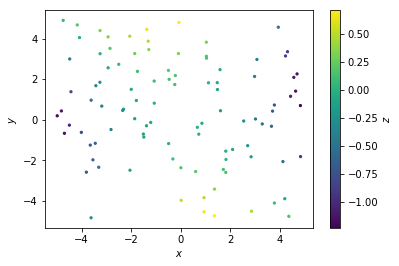

In [5]:
N = 100
xobs = np.random.uniform(-5,5,N)
yobs = np.random.uniform(-5,5,N)
zobs = - 0.05 * xobs**2 + 0.03 * yobs**2 - 0.02 * xobs * yobs
eobs = 0.01
zobs += np.random.normal(0,eobs,len(xobs))
plt.scatter(xobs, yobs, c=zobs, s=20, marker='.')
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
cb = plt.colorbar()
cb.set_label(r'$z$');

### Problem 1a: setting up the GP

Now we will construct the GP model using `george`. We will use a with different length scales in each of the two dimensions. To set this up in george, you have to multiply two individual kernels together, like that:

```
k = a * KernelName(b, ndim = 2, axes = 0) * KernelName(c, ndim = 2, axes = 1)   
```

Here `KernelName` stands for the name of the kernel used (in `george`, the squared exponential kernel is called `ExpSquaredKernel`), `a` is the output variance, `b` is the metric, or length scale, applied to the first input dimension, and `c` to the second. 

Note this is equivalent to the parametrisation used in the lectures:
$$
k(x,x') = A \exp \left[ - \Gamma (x-x')^2\right] = A \exp \left[ - (x-x')^2/m^2\right]
$$
with $\Gamma=1/m^2$.

Go ahead and define the kernel in the cell below, with some ball park values for the hyper-parameters (by ball-park, I mean not too many orders of magnitudes off). Then create a GP object using that kernel. 

In [6]:
k = 1.0 * george.kernels.ExpSquaredKernel(1.0, ndim = 2, axes = 0) * george.kernels.ExpSquaredKernel(1.0, ndim = 2, axes = 1)   
gp = george.GP(k)

Now you will need to tell the GP object what inputs the covariance matrix is to be evaluated at. This is done using the `compute` method. 2-D inputs need to be passed as an $N \times 2$ array, which you will need to construct from the two 1-D arrays of $x$- and $y$-values we generated earlier. The second argument of `compute` should be the white noise standard deviation.

In [7]:
Xobs = np.concatenate([[xobs],[yobs]]).T
gp.compute(Xobs, yerr=eobs)

### Problem 1b: Optimizing the likelihood

Following the example in the first `george` tutorial, define a simple neg log likelihood function, and a function to evaluate its gradient.

In [8]:
def neg_ln_like(p):
    gp.set_parameter_vector(p)
    return -gp.log_likelihood(zobs)

def grad_neg_ln_like(p):
    gp.set_parameter_vector(p)
    return -gp.grad_log_likelihood(zobs)

Note that the parameters which are accessed through the `set_parameter_vector` method are the logarithms of the values used in building the kernel. The optimization is thus done in terms of the log parameters.

Again following the same example, find the hyper-parameters that maximise the likelihood, using `scipy.optimize`'s `minimize` function, and print the results.

In [9]:
from scipy.optimize import minimize
result = minimize(neg_ln_like, gp.get_parameter_vector(), jac=grad_neg_ln_like)
print(result)

      fun: -267.09808542401868
 hess_inv: array([[ 2.74428314,  0.61959279,  1.40138246],
       [ 0.61959279,  0.29555001,  0.31067528],
       [ 1.40138246,  0.31067528,  0.82222766]])
      jac: array([  5.18262386e-05,  -1.22839418e-04,   9.81372432e-06])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 61
      nit: 18
     njev: 45
   status: 2
  success: False
        x: array([ 9.28577056,  8.41791907,  8.85214603])


Now assign those best-fit values to the parameter vector

In [10]:
gp.set_parameter_vector(result.x)

Generate a grid of regularly spaced $x$ and $y$ locations, spanning the range of the observations, where we will evaluate the predictive distribution. Store these in 2-D arrays called `X2D` and `Y2D`. Then convert them into a single 2-D array of shape $N_{\mathrm{pred}} \times 2$, which will be passed to the GP's `predict` method.

*Hint: use `numpy`'s `mrid` function.*

In [11]:
X2D,Y2D = np.mgrid[-6:6:0.5,-6:6:0.5]
Xpred = np.concatenate([[X2D.flatten()],[Y2D.flatten()]]).T

Using the best-fit hyper-parameters, evaluate the mean of the predictive distribution at the grid locations. The output will be a 1-D array, which you will need to reshape so it has the same shape as `X2D` and `Y2D` for plotting.

In [12]:
zpred = gp.predict(zobs, Xpred, return_var=False, return_cov=False)
Z2D = zpred.reshape(X2D.shape)

Execute the cell below to plot contours of the  predictive mean alongside the data.

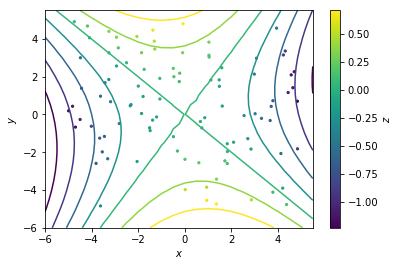

In [14]:
plt.scatter(xobs, yobs, c=zobs, s=20, marker='.')
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
cb = plt.colorbar()
cb.set_label(r'$z$');
plt.contour(X2D,Y2D,Z2D);

Visualising the confidence intervals is a bit tricky in 3-D so we'll skip that. We could use `emcee` to explore the posterior distribution of the hyper-parameters, but we will leave that for a more realistic example.

## Problem 2: Separable functions

In the above problem we were modelling a non-separable function of $x$ and $y$ (because of the cross-term in the polynomial). Now we will model a separable function, and use a GP with a sum rather than a product of kernels to separate the dependence on each of the input variable.

This exploits the fact that GPs preserve additivity. In other words, a GP with a sum of kernels, each depending on a disjoint subset of the inputs, sets up a probability distribution over functions that are sums of functions of the individual subsets of inputs. This is how the K2SC pipeline (for removing pointing systematics in K2 data) discussed in the lectures works.

As ever, we start by simulating a dataset. Execute the cell below.

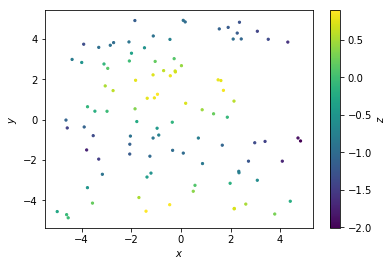

In [16]:
N = 100
xobs = np.random.uniform(-5,5,N)
yobs = np.random.uniform(-5,5,N)
zobs = -0.05 * xobs**2 + np.sin(yobs)
eobs = 0.01
zobs += np.random.normal(0,eobs,len(xobs))
plt.scatter(xobs, yobs, c=zobs, s=20, marker='.')
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
cb = plt.colorbar()
cb.set_label(r'$z$');

### Problem 2a: Joint model

We start, once again, by defining the GP object. The kernel will consist of a sum of 2 squared exponentials, one applied to each dimension. It will be useful to be able to access each of the kernel objects separately later, so start by defining each of the component kernel, assigning them to variables `k1` and `k2`, and then define the overal kernel `k` as the sum of the two. Then define the GP object itself.

In [17]:
k1 = 1.0 * george.kernels.ExpSquaredKernel(1.0, ndim = 2, axes = 0) 
k2 = 1.0 * george.kernels.ExpSquaredKernel(1.0, ndim = 2, axes = 1)   
k = k1 + k2
gp = george.GP(k)
Xobs = np.concatenate([[xobs],[yobs]]).T

Next we want to optimize the likelihood. Luckily we can re-use the neg log likelihood and gradient functions from the previous problem. Start by packaging up the two inputs into a single 2-D vector, as in Problem 1, then use the `minimize` function to evaluate the max. likelihood hyper-parameters.

In [18]:
gp.compute(Xobs, yerr=eobs)
result = minimize(neg_ln_like, gp.get_parameter_vector(), jac=grad_neg_ln_like)
print(result)

      fun: -240.92944661122056
 hess_inv: array([[  2.64836104e+00,   1.09092340e+00,  -1.16464477e-02,
          3.62531967e-04],
       [  1.09092340e+00,   5.52744296e-01,  -2.60581310e-03,
          2.40890101e-04],
       [ -1.16464477e-02,  -2.60581310e-03,   9.21238244e-01,
          1.78929679e-01],
       [  3.62531967e-04,   2.40890101e-04,   1.78929679e-01,
          4.69608797e-02]])
      jac: array([ -2.24565156e-07,   5.24460120e-09,   3.71413989e-07,
        -2.48388710e-06])
  message: 'Optimization terminated successfully.'
     nfev: 30
      nit: 20
     njev: 30
   status: 0
  success: True
        x: array([ 6.15957775,  6.75940202,  1.80640805,  2.18788423])


Now let's plot the predictive distribution to check it worked ok. You can just copy and paste code from Problem 1.

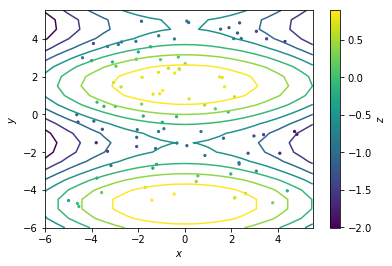

In [19]:
zpred = gp.predict(zobs, Xpred, return_var=False, return_cov=False)
Z2D = zpred.reshape(X2D.shape)
plt.scatter(xobs, yobs, c=zobs, s=20, marker='.')
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
cb = plt.colorbar()
cb.set_label(r'$z$');
plt.contour(X2D,Y2D,Z2D);

### Problem 2b: Separating the components

We now come to evaluating the predictive means for the individual components. The standard expression for the predictive mean is:
$$
\overline{\boldsymbol{y}}_* = K(\boldsymbol{x}_*,\boldsymbol{x}) K(\boldsymbol{x},\boldsymbol{x})^{-1} \boldsymbol{y}
$$
The predictive mean for a given component of the kernel is obtained simply by replacing the first instance of the covariance matrix between test and training points, $K(\boldsymbol{x}_*,\boldsymbol{x})$, by the corresponding matrix for the component in question only:
$$
\overline{\boldsymbol{y}}_{1,*} = K_1(\boldsymbol{x}_*,\boldsymbol{x}) K(\boldsymbol{x},\boldsymbol{x})^{-1} \boldsymbol{y}.
$$

`george` doesn't provide a built-in function to do this, but
- the GP object has a method `apply_inverse`, which evaluates and returns the product $K(\boldsymbol{x},\boldsymbol{x})^{-1} \boldsymbol{y}$ for a given vector of training set outputs $\boldsymbol{y}$,
- the kernel object has a method `get_value`, which evaluates the covariance matrix for a given set of inputs.

Use these two functions to evaluate the two components of the best-fit GP model in our problem. Store the $x$- and $y$ components in variables `fx` and `fy`, respectively.

*Hint: The `apply_inverse` method does what it says in the name, i.e. it modifies its argument by pre-multiplying it by the inverse of the covariance matrix. Therefore, you need to pass it a copy of the vector of obserced outputs, not the original.*

In [21]:
b = np.copy(zobs)
gp.apply_inverse(b)
K1 = k1.get_value(Xobs)
fx = np.dot(K1,b)
K2 = k2.get_value(Xobs)
fy = np.dot(K2,b)

Now execute the cell below to plot the results.

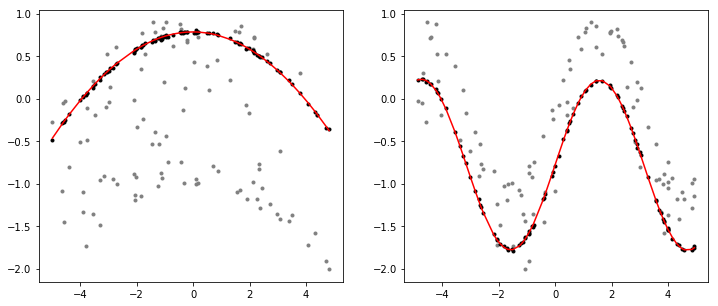

In [22]:
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.plot(xobs,zobs,'.',c='grey')
plt.plot(xobs,zobs-fy,'k.')
s = np.argsort(xobs)
plt.plot(xobs[s],fx[s],'r-')
plt.subplot(122)
plt.plot(yobs,zobs,'.',c='grey')
plt.plot(yobs,zobs-fx,'k.')
s = np.argsort(yobs)
plt.plot(yobs[s],fy[s],'r-');

## Problem 3: Multiple time-series with delays

Consider a situation where we have several time-series, which we expect to display the same behaviour (up to observational noise), except for a time-delay. We don't know the form of the behaviour, but we want to measure the time-delay between each pair of time-series. Something like this might arise in [AGN reverberation mapping](https://en.wikipedia.org/wiki/Reverberation_mapping), for example.

We can do this by modelling the time-series as observations of the same GP, with shifted inputs, and marginalising over the GP hyper-parameters to obtain posterior distribution over the time shifts.

First, let's simulate some data. We will cheat by doing this using a GP, so we know it will work. Execute the cell below.

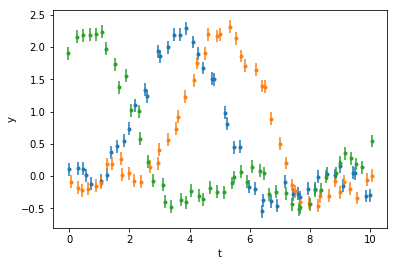

In [23]:
N = 50
M = 3
t2d = np.tile(np.linspace(0,10,N),(M,1))
for i in range(M):
    t2d[i,:] += np.random.uniform(-5./N,5./N,N)
delays_true = [-1.5,3]
t_delayed = np.copy(t2d)
for i in range(M-1):
    t_delayed[i+1,:] = t2d[i,:] + delays_true[i]
gp = george.GP(1.0 * george.kernels.Matern52Kernel(3.0))
gppar_true = gp.get_parameter_vector()
y2d = gp.sample(t_delayed.flatten()).reshape((M,N))
wn = 0.1
y2d += np.random.normal(0,wn,(M,N))
for i in range(M):
    plt.errorbar(t2d[i,:],y2d[i,:].flatten(),yerr=wn,capsize=0,fmt='.')
plt.xlabel('t')
plt.ylabel('y');

### Problem 3a: Initial guesses

Because the function goes up an down, you can probably guess that the likelihood surface is going to be highly multi-modal. So it's important to have a decent initial guess for the time delays.

A simple way to do obtain one would be by cross-correlation, but since the time-series are not regularly sampled (because of the small random term we added to each of the time arrays), we need to interpolate them onto a regular grid first. What better way to do this than with a GP? This will have the added advantage of giving us an initial estimate of the GP hyper-parameters too (we're assuming we don't know them either, though we will assume we know the white noise standard deviation).

First we need to define a GP object, based on a Matern 3/2 kernel with variable input scale and variance. Do this in the cell below.

In [24]:
k = 1.0 * george.kernels.Matern52Kernel(3.0)
gp = george.GP(k)

Now we need to fit each time-series in turn, and compute the mean of the predictive distribution over a tightly sampled, regular grid of time values. If you take care to name our variables right, you can reuse the neg log likelihood and associated gradient functions from Problem 1.

Complete the code below and run it

Individual GP fits: best-fit HPs
[[ 0.03158541  1.55851604]
 [-0.12695356  1.09534342]
 [ 0.07960969  1.54912403]]


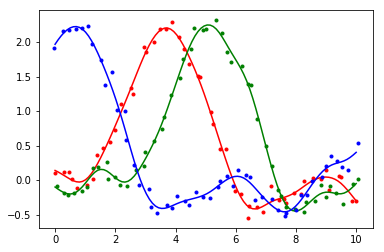

In [25]:
p0 = gp.get_parameter_vector()
# 2-D array to hold the best-fit GP HPs for each time-series
p1 = np.tile(p0,(3,1))
# Regularly sampled time array
treg = np.linspace(0,10,100)
# 2-D array to hold the interpolated time-series
yreg = np.zeros((3,100))
c = ['r','g','b']
for i in range(M):
    # Compute the gp on the relevant subset of the 2-D time array t2d
    gp.compute(t2d[i,:].flatten(),yerr=wn)
    # Assign the corresponding y values to the variable zobs
    # (this is the one that neg_ln_like uses to condition the GP)
    zobs = y2d[i,:].flatten()
    # Optimize the likelihood using minimize
    result = minimize(neg_ln_like, p0, jac=grad_neg_ln_like)
    # Save the best-fit GP HPs in p1
    p1[i,:] = result.x
    # update the GP parameter vector with the best fit values 
    gp.set_parameter_vector(result.x)
    # evaluate the predictive mean conditioned on zobs at locations treg and save in yreg
    yreg[i,:] = gp.predict(zobs,treg,return_var=False,return_cov=False)
    # you might want to plot the results to check it worked
    plt.plot(t2d[i,:],y2d[i,:],'.',c=c[i])
    plt.plot(treg,yreg[i,:],'-',c=c[i])
# And let's print the GP HPs to see if they were sensible.
print('Individual GP fits: best-fit HPs')
print(p1)

Now we are ready to cross-correlate the interpolated time-series. The easiest way to do this is using the function `xcorr` from `matplotlib.pyplot`. This function returns a tuple of 4 variables, the first two of which are the lags and corresponding cross-correlation values.

Estimated time delays from cross-correlation
[-1.51515152  2.72727273]
True delays
[-1.5, 3]


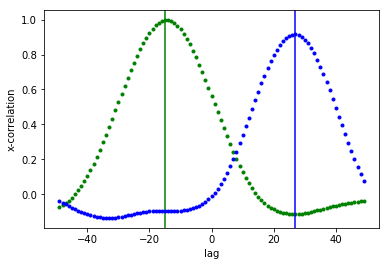

In [26]:
dt = treg[1] - treg[0]
# Array to hold estimates of the time-delays
delays_0 = np.zeros(M-1)
for i in range(M-1):
    # use pyplot's xcorr function to cross-correlate yreg[i+1] with yreg[0]
    lags, corr, _, _ = plt.xcorr(yreg[0,:],yreg[i+1,:],maxlags=49,usevlines=False,marker='.',color=c[i+1])
    # find the lag that maximises the CCF, convert it to time delay, save in delays_0 array
    lmax = lags[np.argmax(corr)]
    plt.axvline(lmax,color=c[i+1])
    delays_0[i] = dt * lmax
plt.xlabel('lag')
plt.ylabel('x-correlation');
# Compare estimated to true delays
print('Estimated time delays from cross-correlation')
print(delays_0)
print('True delays')
print(delays_true)

As you can see, the delays estimated in this way aren't too far off.

To get initial guesses for the GP hyper-parameters, we can take the mean of the best-fit values from the three individual time-series. Do this in the cell below.

In [27]:
gppar_0 = np.mean(p1,axis=0)
print('Estimated GP HPs')
print(gppar_0)
print('True GP HPs')
print(gppar_true)

Estimated GP HPs
[-0.00525282  1.4009945 ]
True GP HPs
[ 0.          1.09861229]


The GP HPs aren't too far off either.

### Problem 3b: Optimization

Now we have some initial guesses for the time-delays and the GP hyper-parameters, we're ready to model the time-series simultaneously, using a single GP. We need to write a new likelihood function to do this. The function will need to apply the delays to the times, before passing these times to `george` to evaluate the likelihood itself. 

First let's define a function `apply_delays`, which will take the delays and the time array `t` as inputs, and return an $M \times N$ array of delayed times. This function will be called by the likelihood function, but it might be useful later for plotting the results too. It would also be useful for this function to warn us if the time-delays are such that one of the time-series no longer overlaps with the others at all, for example by returning a boolean variable that is true if all is well, but false if not.

Complete the definition below.

In [28]:
def apply_delays(delays,t2d):
    t_delayed = np.copy(t2d)
    for i, delay in enumerate(delays):
        t_delayed[i+1,:] += delay
    ok = True
    M = len(delays) + 1
    for i in range(M):
        tc = t_delayed[i,:]
        to = t_delayed[np.arange(M)!=i,:]
        if (tc.min() > to.max()) + (tc.max() < to.min()):
            ok = False
    return t_delayed, ok

Now we are ready to define the likelihood function itself. The likelihood should accept a parameter array consisting of the shifts first, and then the GP hyper-parameters, and make use of the output of `apply_delays` to return a very high number if the time delays are unreasonable. Complete the definition below.

In [29]:
def neg_ln_like_delays(p):
    delays = p[:-2]
    t_delayed, ok = apply_delays(delays,t2d)
    if not ok: 
        return 1e25
    gp.set_parameter_vector(p[-2:])
    gp.compute(t_delayed.flatten(), yerr=wn)
    return -gp.log_likelihood(y2d.flatten())

There is no simple analytical way to evaluate the gradient of the log likelihood with respect to the time delays, so we will not define a `grad_neg_log_like` function for this problem. The gradient descent optimizer will be slower, since it will have to evaluate the gradients numerically, but for such a small dataset it doesn't matter.

Ok, now we are ready to run the optimizer. Like before, we can use the `minimize` function from `scipy.optimize`.

In [30]:
ptrue = np.concatenate([delays_true,gppar_true]) 
p0 = np.concatenate([delays_0,gppar_0])
print('Initial guesses')
print(p0)
result = minimize(neg_ln_like_delays, p0)
p1 = np.array(result.x)
print('ML parameters')
print(p1)
print('True parameters')
print(ptrue)

Initial guesses
[-1.51515152  2.72727273 -0.00525282  1.4009945 ]
ML parameters
[-1.47460121  3.02198447 -0.35936178  1.11171855]
True parameters
[-1.5         3.          0.          1.09861229]


As you can see, the optimization further improved our estimates of the time delays and the GP HPs. But how much can we trust these? Let's evaluate posterior uncertainties using MCMC.

### Hyper-parameter marginalisation.

We now use MCMC to obtain uncertainty estimates, or confidence intervals, for the model hyper-parameters. 

First we need to define the posterior function to pass to the `emcee` sampler. We will use improper, flat priors over all the parameters, so the posterior probability is just a trivial wrapper around our `neg_ln_like_delays` function. Complete the definition below:

In [31]:
def lnprob(p):
    return -neg_ln_like_delays(p)

Next, we set up the sampler. We will use 32 walkers, and initialise each set of walkers using the maximum likelihood estimates of the parameters plus a small random offset. Complete the code below, using the second `george` tutorial as an example.

In [32]:
ndim, nwalkers = len(p1), 32
p2 = p1 + 1e-4 * np.random.randn(nwalkers, ndim)
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)

Now we are ready to run the MCMC, starting with a burn-in chain of 500 steps, after which we reset the sampler, and run the sampler again for 100 iterations. Complete the code below.

In [33]:
print("Running burn-in...")
p2, _, _ = sampler.run_mcmc(p2, 50)
sampler.reset()

print("Running production...")
sampler.run_mcmc(p2, 500);

Running burn-in...
Running production...


Next we use the `corner` function from the `corner` module to plot the posterior distributions over the parameters. Complete the code below.

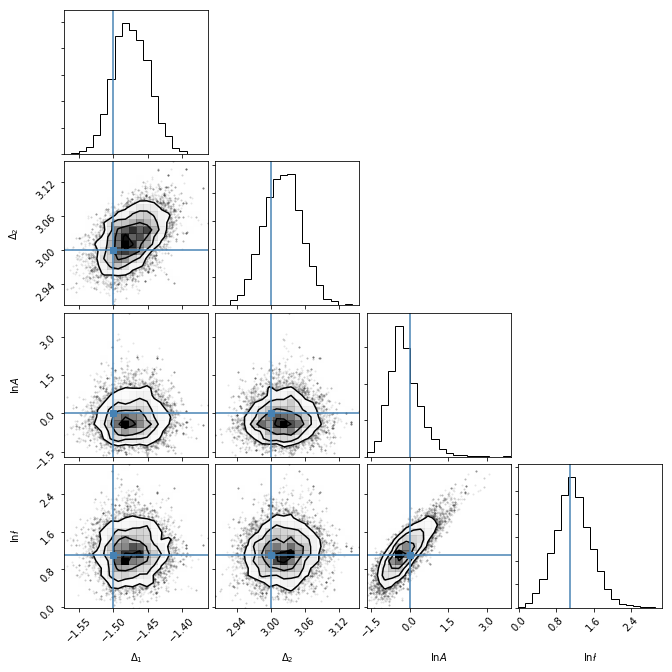

In [34]:
labels = [r"$\Delta_1$", r"$\Delta_2$", r"$\ln A$", r"$\ln\l$"]
truths = ptrue
corner.corner(sampler.flatchain, truths=truths, labels=labels);

Hopefully the distributions should look reasonable and be consistent with the true values. 

We need to extract confidence intervals for the parameters from the MCMC chain, which we can access through `sampler.flatchain`

In [35]:
samples = sampler.flatchain[:]
# The GP parameters were explored in log space, return them to linear space
#samples[:, -2:] = np.exp(samples[:, -2:])
# This handy bit of code will extract median and +/- 1 sigma intervals for each parameter
pv = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]), zip(*np.percentile(samples, [16, 50, 84], axis=0)))
# Print the results
for i in range(ndim):
    pval = pv[i]
    print("Param {}: {:5.2f} +{:4.2f} -{:4.2f} (true: {:5.2f})".format(i+1,pval[0], pval[1], pval[2], ptrue[i]))

Param 1: -1.47 +0.03 -0.02 (true: -1.50)
Param 2:  3.02 +0.03 -0.03 (true:  3.00)
Param 3: -0.27 +0.64 -0.49 (true:  0.00)
Param 4:  1.15 +0.40 -0.36 (true:  1.10)


Hopefully, the MCMC estimates should be consistent with the true values...

## Challenge problem: Active scheduling

Imagine you are monitoring a particular variable, you want to know its value to a given precision at anyone time, but each observation is costly, so you don't want to take any more than you have to. You can train a GP on the first few observations, then use the predictive distribution to work out when your uncertainty about the current value of the variable is so large that you need to take a new observation. Use the new observation to update the GP hyper parameters and the predictive distribution, and repeat the process...

First we generate a tightly sampled time series over 100 days. This will represent the "true" value of the variable. We will include some periodic behaviour as that makes the problem more interesting. Then we will "observe" 1 point per day for the first 20 days.

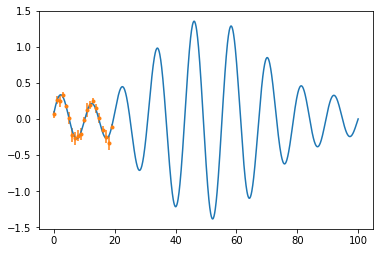

In [36]:
xtrue = np.linspace(0,100,1000)
k = george.kernels.CosineKernel(np.log(12.3)) * george.kernels.ExpSquaredKernel(1000.0)
ytrue = george.GP(k).sample(xtrue)
xobs = xtrue[:200:10]
eobs = 10.0**(np.random.uniform(-1.5,-1,20))
yobs = ytrue[:200:10] + np.random.normal(0,1,20) * eobs
plt.plot(xtrue,ytrue)
plt.errorbar(xobs,yobs,yerr=eobs,fmt='.',capsize=0);

Your task is to devise and implement an algorithm that will schedule observations, based on the data to date, so as to ensure the uncertainty on the value of the function at any one time never exceeds 0.1. At each step, the aglorithm should:
- train a GP on the data acquired so far. You may assume the form of the covariance function is known, as is the output variance, so there are only two hyper-parameters to fit (the log period of the cosine kernel and the metric of the squared exponential term).
- make predictions for future values. If you're being clever, you can do this sequentially so you only look ahead a small time interval at a time, and stop as soon as the uncertainty exceeds the desired bound.
- use this to decide when to take the next observation
- add the next observation (by sampling the "true" values at the appropriate time and adding noise with the same distribution as above)
- repeat till the end time is reached.

Of course you will need to test your algorithm by comparing the predictions to the true values.

      fun: -23.048040082083055
 hess_inv: array([[  1.79566325e-03,  -3.62569466e-02],
       [ -3.62569466e-02,   2.34606032e+00]])
      jac: array([  3.22511369e-08,   2.71357359e-09])
  message: 'Optimization terminated successfully.'
     nfev: 17
      nit: 10
     njev: 17
   status: 0
  success: True
        x: array([  2.3282548 ,  10.40042453])


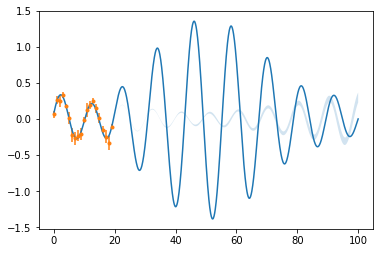

In [37]:
gp = george.GP(k)
gp.set_parameter_vector([np.log(10),np.log(1000)])
gp.compute(xobs,yerr=eobs)
def nll(p):
    gp.set_parameter_vector(p)
    return -gp.log_likelihood(yobs)
def gnll(p):
    gp.set_parameter_vector(p)
    return -gp.grad_log_likelihood(yobs)
result = minimize(nll, gp.get_parameter_vector(), jac=gnll)
print(result)
gp.set_parameter_vector(result.x)
ypred, epred = gp.predict(yobs, xtrue, return_var=True)
plt.plot(xtrue,ytrue)
plt.errorbar(xobs,yobs,yerr=eobs,fmt='.',capsize=0);
plt.fill_between(xtrue,ypred + epred, ypred-epred,alpha=0.2,edgecolor='none')
